#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import os
import torch
from fusion import get_conf_region, plot_pts_in_conf_region
np.random.seed(42)

#### ARMAX class

In [ ]:
class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = np.array(A)
        self.B = np.array(B)
        self.C = np.array(C)
        self.F = np.array(F)
        self.L = np.array(L)
        # np.random.seed(42)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = np.zeros(n_samples)
        U = np.zeros(n_samples)
        N = np.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = np.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- np.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + np.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + np.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (np.dot(self.L, R[t:t-len(self.L):-1]) 
                    - np.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

#### SPS indirect class

In [3]:
from sps_indirect import SPS_indirect_model, d_tfs

#### SPS confidence region for nth order system

##### get_conf_region()

##### plot_pts_in_conf_region()

##### example: first order system

14.1% of tested points were in confidence region


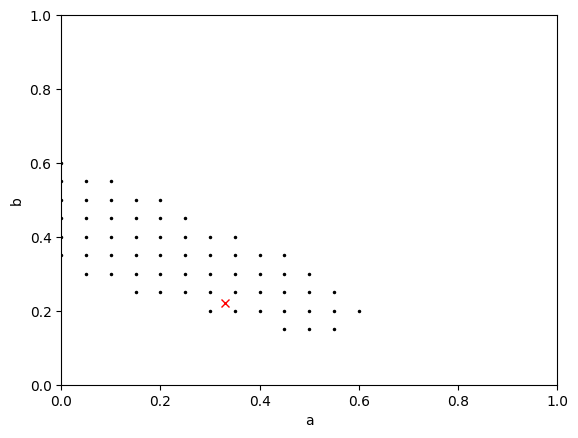

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen

A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1
armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave reference
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model creation

m = 100
q = 5
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ confidence region

n_a = 1
n_b = 1
region_bounds = [[0, 1.0], [0, 1.0]]
granularity = [21, 21]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
pct = 100 * len(pts_in_conf_region) / np.prod(granularity)
print(f"{pct:.1f}% of tested points were in confidence region", )

# first order system
fig, axes = plt.subplots()
plot_pts_in_conf_region(pts_in_conf_region, x_dim=0, y_dim=1, true_param=[-A[1], B[1]], fig=fig, ax=axes)
axes.set_xlim(0,1)
axes.set_ylim(0,1)
axes.set_xlabel("a")
axes.set_ylabel("b")
plt.show()

##### example: n_a=2, n_b=2

1.5% of tested points were in confidence region
SPS indicator returns True with actual system parameters: True
Actual system parameters were in the returned confidence region: False


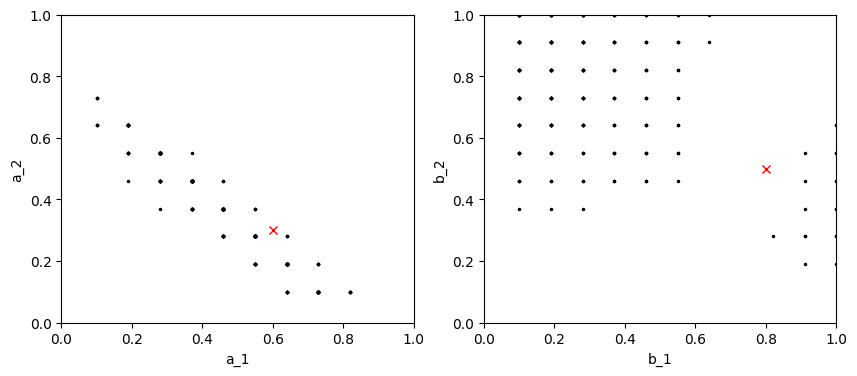

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ define system and generate data

A  = [1, -0.6, -0.3]
B = [0.8, 0.5]
C = [1, 0.2, 0.04]
F = [0.3, 0.2, 0.1] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 100
R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.05)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

B = [0] + B
G = (B, A)
H = (C, A)

F = (F, [1])
L = (L, [1])

m = 20
q = 1
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

n_a = 2
n_b = 2
region_bounds = [[0.1, 1.0], [0.1, 1.0], [0.1, 1.0], [0.1, 1.0]]
granularity = [11, 11, 11, 11]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
pct = 100 * len(pts_in_conf_region) / np.prod(granularity)
print(f"{pct:.1f}% of tested points were in confidence region", )

G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)
print(f"SPS indicator returns True with actual system parameters: {in_sps}")

target = np.array([0.8, 0.3, 0.8, 0.5])
assert len(pts_in_conf_region) > 0
idx = np.where(np.all(np.isclose(pts_in_conf_region, target, atol=1e-6), axis=1))
in_list = idx[0].size != 0
print(f"Actual system parameters were in the returned confidence region: {in_list}")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot confidence region

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10,4))
plot_pts_in_conf_region(pts_in_conf_region, x_dim=0, y_dim=1, true_param=[-A[1], -A[2]], fig=fig, ax=axes[0])
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].set_xlabel("a_1")
axes[0].set_ylabel("a_2")
plot_pts_in_conf_region(pts_in_conf_region, x_dim=2, y_dim=3, true_param=[B[1], B[2]], fig=fig, ax=axes[1])
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].set_xlabel("b_1")
axes[1].set_ylabel("b_2")
plt.show()

In [14]:
len(pts_in_conf_region)

221

In [ ]:
np.prod(granularity)

14641

In [8]:
from scipy.io import savemat
savemat("pts_in_conf_region_2_2.mat", {"pts_in_conf_region": pts_in_conf_region})

In [9]:
from optimal_controls import tf_to_ocf
tf_to_ocf(B,A)

c:\Users\conor\anaconda3\envs\capstone_v2\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


(array([[0. , 0.3],
        [1. , 0.6]]),
 array([[0.5],
        [0.8]]),
 array([[0., 1.]]))

##### example: n_a=2, n_b=1

In [12]:
#   z^3 - 1.4 z^2 + 0.68 z - 0.12
#   ------------------------------
#   z^3 - 2.1 z^2 + 1.16 z - 0.096
tf_to_ocf([0, 1, -0.8, 0.2], [1, -2.1, 1.16, -0.096])

(array([[ 0.   ,  0.   ,  0.096],
        [ 1.   ,  0.   , -1.16 ],
        [ 0.   ,  1.   ,  2.1  ]]),
 array([[ 0.2],
        [-0.8],
        [ 1. ]]),
 array([[0., 0., 1.]]))

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ define system and generate data

a1 = -0.9
a2 = -0.1
b1 = 0.8

A  = [1, -a1, -a2]
B = [b1]
C = [1, 0.2, 0.04]
F = [0.3, 0.2] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 200
R = np.sign(np.sin(np.linspace(0, 5*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.05)
# armax_model.plot_results(Y, U, N, R)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS model definitions

B = [0] + B
G = (B, A)
H = (C, A)

F = (F, [1])
L = (L, [1])

m = 20
q = 1
model = SPS_indirect_model(m, q)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

n_a = 2
n_b = 1
region_bounds = [[-2, 2], [-2, 2], [0.1, 1]]
granularity = [41, 41, 10]
# region_bounds = [[0.6, 0.8], [0.2, 0.4], [0.7, 0.9]]
# granularity = [21, 21, 21]

pts_in_conf_region = get_conf_region(region_bounds, granularity, model, n_a, n_b, C, L, F, Y, R)
pct = 100 * len(pts_in_conf_region) / np.prod(granularity)
print(f"{pct:.1f}% of tested points were in confidence region", )

G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)
print(f"SPS indicator returns True with actual system parameters: {in_sps}")

target = np.array([a1, a2, b1])
assert len(pts_in_conf_region) > 0
idx = np.where(np.all(np.isclose(pts_in_conf_region, target, atol=1e-6), axis=1))
in_list = idx[0].size != 0
print(f"Actual system parameters were in the returned confidence region: {in_list}")


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot confidence region

plt.switch_backend('TkAgg')  # or 'Qt5Agg'

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pts_in_conf_region[:,0], pts_in_conf_region[:,1], pts_in_conf_region[:,2])
ax.scatter(-A[1], -A[2], B[1], 'r', s=400)
ax.set_xlabel('a_1')
ax.set_ylabel('a_2')
ax.set_zlabel('b_1')
# plt.show()

plt.show(block=True)

from scipy.io import savemat
savemat("pts_in_conf_region.mat", {"pts_in_conf_region": pts_in_conf_region})

1.4% of tested points were in confidence region
SPS indicator returns True with actual system parameters: True
Actual system parameters were in the returned confidence region: True


##### Debugging